# Coding an LLM architecture

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257, # used by the BPE tokenizer
    "context_length" : 1024,
    "emb_dim" : 768, # each input token is transformed in a 768-dimensional embedding
    "n_heads" : 12, # number of attention-heads in multi-head-attention mechanism
    "n_layers" : 12,
    "drop_rate" : 0.1, # dropout regularization
    "qvb_bias" : False # query-key-value bias
}

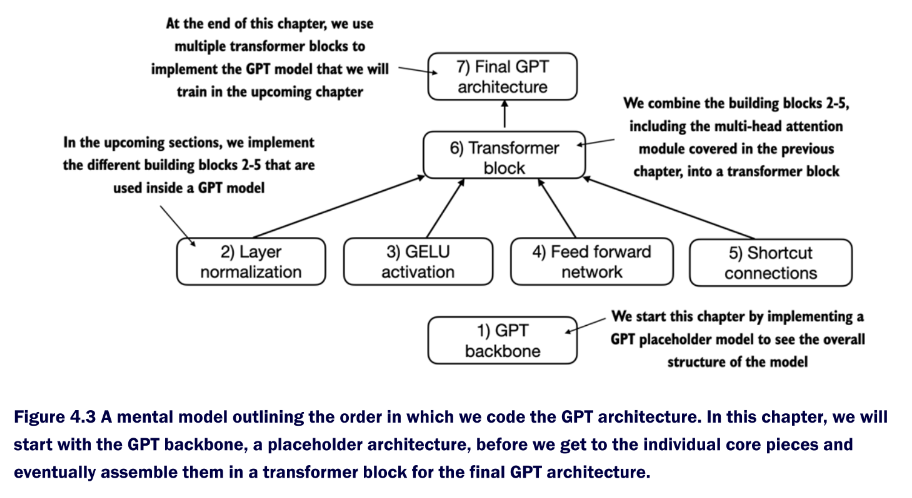

# 1\. GPT Backbone

In [ ]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])  # embedding dictionary
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) # positional embeddings
    self.drop_emb = nn.Dropout(cfg["drop_rate"]) # dropout layer

    self.tfr_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg) # dummy transformer blocks
        for _ in range(cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"]) # dummy layer normalization step

    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias = False #
    )

  def forward(self, in_idx):
    batch_size, seq_length = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_length, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds # input tokens creation with positional embeddings
    x = self.drop_emb(x) # dropout layer
    x = self.tfr_blocks(x) # transformer blocks
    x = self.final_norm(x) # layer normalization
    logits = self.out_head(x) # final layer
    return logits

# dummy layers to be defined later
# transformer block
class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
  def forward(self, x):
    return x
# normalization layer
class DummyLayerNorm(nn.Module):
  def __init__(self, cfg):
    super().__init__()
  def forward(self, x):
    return x

## 🧠 Il Layer di Output: La "Testa di Proiezione"

Un componente cruciale del modello è il layer lineare finale, spesso chiamato "testa di proiezione" (projection head) o "testa di linguaggio" (language model head). È il componente che traduce la rappresentazione interna del modello (lo spazio degli embedding) di nuovo nello spazio del vocabolario.

```python
self.out_head = nn.Linear(
    cfg["emb_dim"], cfg["vocab_size"], bias = False
    )
```

### 1\. Scopo e Funzionamento

Il compito di questo layer è molto specifico: prendere l'output dell'ultimo blocco Transformer e, per **ciascun token** nella sequenza, generare un punteggio per **ogni parola** nel vocabolario.

  * **Input**: Il tensore `x` che esce dall'ultimo blocco Transformer. Ha una forma `(Batch_Size, Seq_Len, emb_dim)`.
  * **Output**: Un tensore di **logits** (punteggi grezzi, non normalizzati).

Nel metodo `forward`, questo è l'ultimo passaggio:

```python
# x ha shape [Batch_Size, Seq_Len, emb_dim]
logits = self.out_head(x)
# logits ha shape [Batch_Size, Seq_Len, vocab_size]
return logits
```

Per ognuno dei `Seq_Len` token in input, il modello produce un vettore di `vocab_size` numeri.

### 2\. Dai Logits alle Probabilità

È fondamentale capire che l'output `logits` **non è una distribuzione di probabilità**. Sono solo punteggi grezzi. Un punteggio più alto significa semplicemente che il modello ritiene quel token più probabile.

Per convertire questi punteggi in una distribuzione di probabilità (dove tutti i valori sono tra 0 e 1 e la loro somma è 1), applichiamo la funzione **Softmax** lungo l'ultima dimensione:

```python
import torch.nn.functional as F

# probabilities avra' sempre shape [Batch_Size, Seq_Len, vocab_size]
probabilities = F.softmax(logits, dim=-1)
```

Ora, `probabilities[b, t, :]` è un vettore di `vocab_size` probabilità che rappresenta la previsione del modello per il token che dovrebbe seguire il token `t` nella sequenza `b`.

### 3\. La Formulazione Matematica

L'operazione è una moltiplicazione di matrici:

$$Z = V_n W$$

Dove:

1.  $V_n \in M(N,d)$ - È l'input `x`, l'output finale dei blocchi Transformer.
2.  $W \in M(d,D)$ - È la matrice dei pesi del layer `self.out_head`. Trasforma un vettore di embedding (dimensione $d$) in un token ID (dimensione $D$)
3.  $Z \in M(N,D)$ - È l'output, il tensore `logits`.

E le dimensioni sono:

  * $N$ - Numero di token nella sequenza (`Seq_Len`).
  * $d$ - Dimensione dello spazio di embedding (`emb_dim`).
  * $D$ - Dimensione del vocabolario (`vocab_size`).

### 4\. Utilizzo in Fase di Generazione

Come hai giustamente notato, questo è il meccanismo usato per generare nuovo testo. Il processo (semplificato) è:

1.  Si fornisce al modello una sequenza di token di input $X$.
2.  Si esegue il passo `forward` per ottenere i `logits`.
3.  Si considerano **solo i logits dell'ultimo token** della sequenza, `logits_ultimo = logits[:, -1, :]`. Questo tensore ha forma `(Batch_Size, vocab_size)` e rappresenta la previsione del modello per il token *successivo*.
4.  Si applica il `softmax` a `logits_ultimo` per ottenere le probabilità.
5.  Si "campiona" da questa distribuzione per scegliere il token successivo. Ad esempio, un campionamento *greedy* (come nel tuo esempio) sceglie semplicemente il token $D_i$ con la probabilità più alta (l'indice con il logit più alto).

-----

### 💡 Nota Didattica: `bias=False` e *Weight Tying*

Hai notato `bias = False` nella definizione del layer? Questa è una scelta progettuale molto importante e comune nei modelli Transformer.

Molte implementazioni (inclusa quella originale di "Attention Is All You Need" e GPT-2) usano una tecnica chiamata **Weight Tying** (condivisione dei pesi).

L'idea è che la matrice dei pesi del layer di **embedding di input** (che mappa `vocab_size` -\> `emb_dim`) e la matrice dei pesi di questo **layer di output** (che mappa `emb_dim` -\> `vocab_size`) dovrebbero essere **le stesse** (o meglio, una la trasposta dell'altra).

**Perché?**

1.  **Efficienza dei Parametri**: La matrice dei pesi $W \in M(d,D)$ è enorme, poiché $D$ (`vocab_size`) è spesso \> 50.000. Condividendola con il layer di embedding, si dimezza quasi il numero di parametri del modello.
2.  **Intuizione Modellistica**: Ha senso che la "mappa" per trasformare un ID token in un vettore (`embedding`) sia legata alla mappa per trasformare un vettore di nuovo in un punteggio per quell'ID token (`output head`).

Quando si implementa il *weight tying*, il layer lineare di output non deve avere un bias, ed è per questo che si imposta `bias=False`.

## ⚙️ How the model works

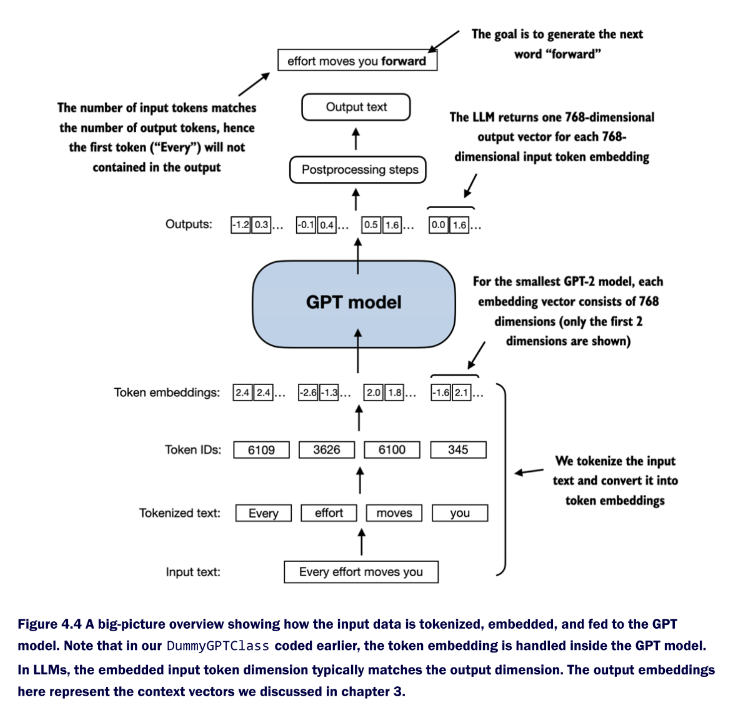

In [ ]:
# input tokens creation
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)
print("Token IDs: \n", batch)

In [ ]:
# inizializzazione del modello
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape: ", logits.shape)
print(logits)

In [ ]:
# generazione dei token output: il token associato alla probabilita piu alta secondo il vettore di logit di output
probs = torch.softmax(logits, dim = -1)
pred_toks = torch.argmax(probs, dim = -1)
print(pred_toks)

# Conversione del tensore ad una lista di interi
print(tokenizer.decode_batch(pred_toks.tolist()))

Visto che ancora non abbiano allenato il modello, e normale ottenere un output completamente casuale.

# 2\. Layer Normalization

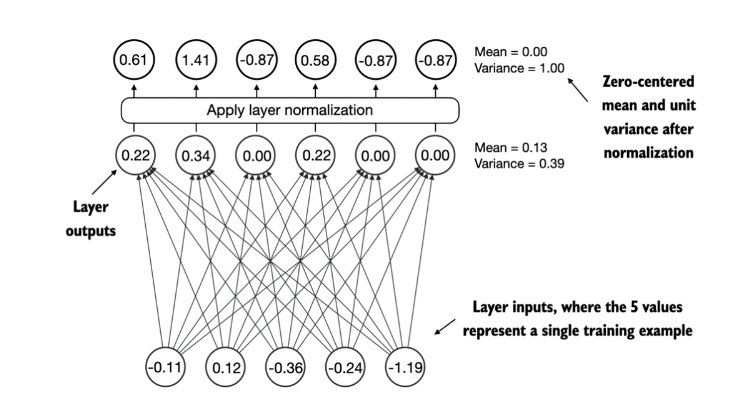

In [ ]:
# esempio

torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU()) # matrice dei pesi
out = layer(batch_example)
print("Non-normalized output: \n", out)

# calcolo di media e varianza dell'output
mean = out.mean(dim=-1, keepdim=True) # lungo l'ultima dimensione del tensore, ovvero lungo le righe
var = out.var(dim=-1, keepdim=True) # mantenendo la shape originale, ovvero [2,1]
print("Mean: \n", mean)
print("Var: \n", var)

# normalizzazione
norm_out = (out - mean)/var**0.5 # operazione riga per riga sul tensore out
print("Normalized output: \n", norm_out)

In [ ]:
# implementazione del layer di normalizzazione
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 # per evitare di dividere per zero
    self.scale = nn.Parameter(torch.ones(emb_dim)) # parametri aggiuntivi allenabili
    self.shift = nn.Parameter(torch.zeros(emb_dim)) # parametri aggiunti allenabili

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale * x + self.shift # operazioni elemento per elemento

I parametri `scale` e `shift` sono aggiunti in maniera tale che il modello possa imparare l'appropriato shift e scaling dei dati che sta processando durante l'allenamento.

Questi parametri vengono inizializzati in maniera tale da non avere nessun effetto sull'output `x`.

In [ ]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, keepdim = True, unbiased = False)
print("Mean after normalization: \n", mean)
print("Variance after normalization: \n", var)

# 3\. GELU Activation

$$ \text{GELU}(x) = x \cdot \Phi(x) $$

Dove $\Phi(x)$ è la funzione di distribuzione cumulativa (CDF) della distribuzione normale standard.

Un'approssimazione comune e spesso utilizzata è:

$$ \text{GELU}(x) \approx 0.5x \left(1 + \tanh \left[ \sqrt{2/\pi} \left( x + 0.044715x^3 \right) \right] \right) $$

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5*x*(1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) *
        (x+0.044715*torch.pow(x,3))
    ))

In [ ]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize = (8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1,2,i)
  plt.plot(x,y)
  plt.title(f"{label} activation function")
plt.tight_layout()
plt.show()

I dati in input prima vengono proiettati in uno spazio quattro volte piu grande e poivengono riportati in uno spazio di pari dimensione rispetto a quello originale. Questa espansione-contrazione permette alla rete di esplorazione uno spazio rappresentativo piu ricco, offrendo un maggior numero di possibilita di modellazione.

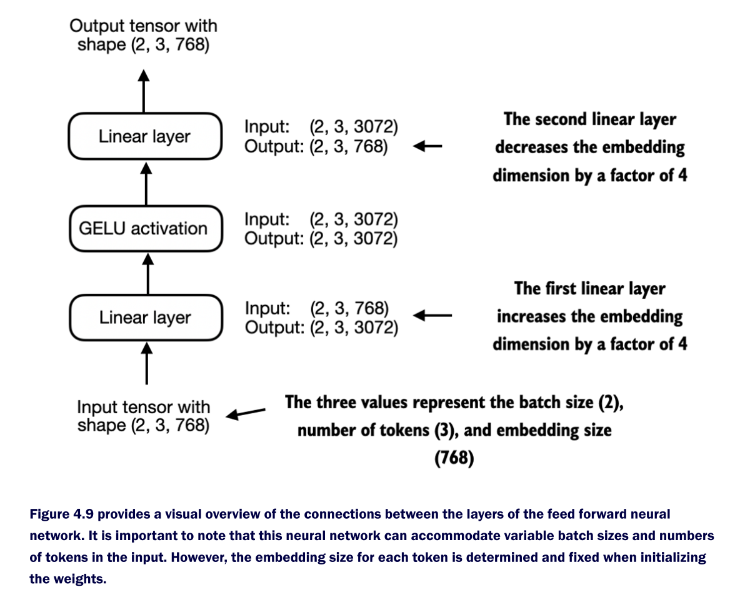

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

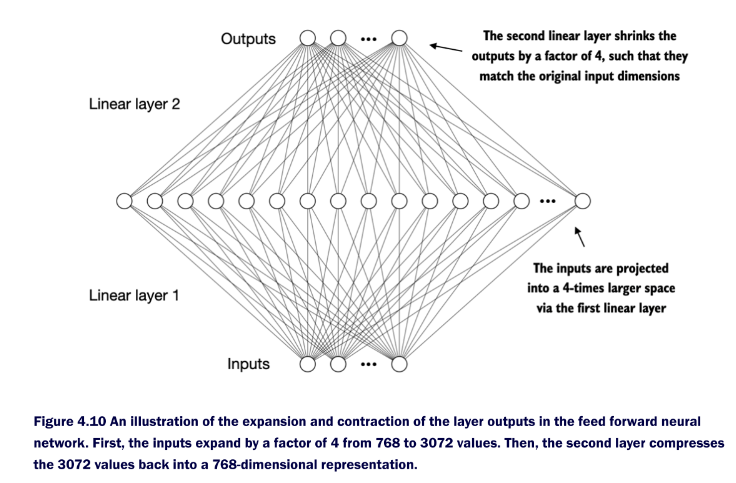

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

# 4\. Residual Connections

## 👻 Le Connessioni Residue: L'"Autostrada" del Gradiente

Una delle innovazioni più importanti che ha permesso la creazione di modelli *deep* (molto profondi) come i Transformer è l'introduzione delle **connessioni residue** (o *residual connections*), un concetto preso in prestito dalla "Residual Network" (ResNet).

Il tuo modello GPT è composto da molti blocchi Transformer impilati uno sull'altro. Senza connessioni residue, addestrare una rete così profonda sarebbe quasi impossibile a causa del problema della **scomparsa del gradiente** (*vanishing gradient*).

### 1. Il Problema: Il Gradiente Scompare

Durante la backpropagation, il segnale di gradiente (che dice alla rete *come* aggiornare i pesi) deve viaggiare all'indietro dall'output fino all'input, passando attraverso ogni singolo layer. In una rete molto profonda, questo gradiente viene moltiplicato ripetutamente per i pesi di ogni layer. Se queste moltiplicazioni producono numeri piccoli (<1), il gradiente si "estingue" (diventa quasi zero) prima di raggiungere i layer iniziali, che smettono di imparare.

### 2. La Soluzione: La Connessione "Shortcut"

L'apprendimento residuo (o *residual learning*) affronta questo problema in modo sorprendentemente semplice: **aggiunge l'input del blocco al suo output**.

Si crea un "blocco residuo" dove l'output $H(x)$ non è solo il risultato della trasformazione $F(x)$ (es. il layer di attenzione o il feed-forward), ma la **somma** dell'input $x$ e della trasformazione $F(x)$.

La formula che hai scritto è quasi corretta, ma è più chiaro scriverla così:

$$H(x) = x + F(x)$$

Dove:
* $x$ è l'input del blocco (l'identità).
* $F(x)$ è la trasformazione eseguita dal blocco (es. il blocco di Multi-Head Attention o il Feed-Forward). $F(x)$ contiene tutti i parametri allenabili $w$.
* $H(x)$ è l'output finale del blocco.

### 3. Perché Funziona? La Matematica del Gradiente

Questa semplice addizione `+ x` ha un effetto profondo sulla backpropagation. Quando calcoliamo il gradiente (la derivata) che deve fluire all'indietro attraverso questo blocco, grazie alla regola della catena otteniamo (in modo semplificato):

$$\frac{\partial H}{\partial x} = \frac{\partial (x + F(x))}{\partial x} = \frac{\partial x}{\partial x} + \frac{\partial F(x)}{\partial x} = 1 + \frac{\partial F(x)}{\partial x}$$

**Questo `+ 1` è la chiave.**

Significa che il gradiente che fluisce all'indietro ha due percorsi:
1.  **Attraverso $F(x)$**: Questo percorso ( $\frac{\partial F(x)}{\partial x}$ ) può soffrire di *vanishing gradient* se il blocco $F$ è complesso.
2.  **Attraverso $x$**: Questo percorso (il `+ 1`) agisce come una "scorciatoia" o **un'autostrada per il gradiente**. Garantisce che, anche se il percorso 1 fallisce e il suo gradiente diventa zero, un gradiente "puro" (moltiplicato per 1) possa comunque fluire all'indietro senza ostacoli attraverso la connessione identità $x$.

Questo assicura che anche i layer più profondi e iniziali della rete ricevano un segnale di gradiente utile per l'apprendimento.

> **In sintesi**: Le connessioni residue permettono al modello di imparare più facilmente la funzione identità ($F(x)$ può semplicemente diventare zero), ma soprattutto creano un percorso diretto per il gradiente, combattendo la sua scomparsa e permettendoci di addestrare reti molto più profonde.

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i+1]), GELU())
        for i in range(len(layer_sizes) - 1)
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

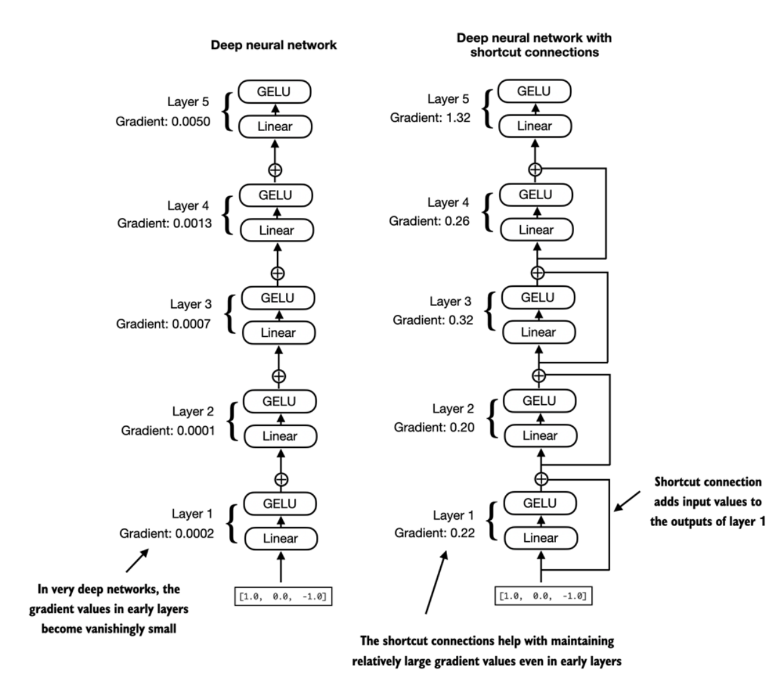

In [ ]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([1.,0.,-1.])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, False)

In [ ]:
# esempio: funzione di loss MSE, propagazione del gradiente (backpropagation)
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([0.])

  # calcolo della funzione di loss
  loss = nn.MSELoss()
  loss = loss(output, target)

  loss.backward() # backpropagation

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')

In [ ]:
# il gradiente scompare dall'ultimo layer, il quarto, al primo.
print_gradients(model_without_shortcut, sample_input)

In [ ]:
# il gradiente non scompare nel caso in cui vengano considerate le connessioni residue.
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=1
)
print_gradients(model_with_shortcut, sample_input)

# 5\. The transformer block

Adesso non rimane che mettere tutto insieme e creare il mattoncino di base deel modello GPT-like che vogliamo costruire.

## 🤖 I Due Motori del Blocco Transformer

All'interno di ogni singolo blocco Transformer, l'elaborazione dei dati avviene attraverso due sotto-layer (o moduli) principali, che lavorano in sequenza. Questi due moduli hanno scopi distinti ma complementari: uno gestisce la **comunicazione tra i token**, l'altro l'**elaborazione di ogni singolo token**.



### 1. Il Modulo di "Comunicazione": Masked Multi-Head Attention

Questo è il componente **"sociale"** del blocco. Il suo compito è permettere ai token di "parlarsi" e scambiarsi informazioni.

* **Cosa fa:** Analizza le relazioni **tra** tutti i token nella sequenza. Per ogni token, decide quali altri token nella sequenza sono importanti per definirne il significato in quel preciso contesto.
* **Come lo fa:** Calcola il nuovo embedding per un token come una **somma pesata** degli embedding degli altri token. I "pesi" di questa somma sono calcolati dinamicamente e si basano sulla **similarità** (o rilevanza) tra i token. Un token "presterà più attenzione" ai token che ritiene più simili o utili.
* **Il dettaglio "Masked":** In un modello GPT-like (un *decoder*), questa attenzione è "mascherata" (causale). Ciò significa che un token in posizione `i` può guardare e prendere informazioni **solo** dai token che lo precedono (da `0` a `i`). Questo è fondamentale per garantire che il modello, durante la generazione, non "sbirci" le risposte future.

> **In breve:** L'attention aggrega e mescola le informazioni *attraverso la dimensione della sequenza*. È un'operazione di **mixing contestuale**.

### 2. Il Modulo di "Elaborazione": Rete Feed-Forward (FFN)

Questo è il componente **"privato"** o **"cognitivo"** del blocco. Dopo che ogni token ha raccolto il contesto dai suoi vicini (tramite l'attention), ha bisogno di "pensare" ed elaborare queste nuove informazioni.

* **Cosa fa:** Applica una trasformazione non lineare complessa per "raffinare" il significato di ogni token, ora arricchito dal contesto.
* **Come lo fa:** È tipicamente una semplice rete neurale (es. due layer lineari con un'attivazione come GELU o ReLU) che viene applicata **indipendentemente ad ogni posizione**.
* **Punto chiave:** A differenza dell'attention, i token qui **non** interagiscono tra loro. La *stessa* rete FFN (con gli stessi pesi allenabili) viene applicata a ogni token della sequenza, uno per uno, come se fossero in "stanze separate".

> **In breve:** La FFN opera *attraverso la dimensione dell'embedding*. È un'operazione di **elaborazione posizionale**.

### Riepilogo del Flusso

L'alternanza di questi due moduli è la magia del Transformer:

1.  **Masked Attention (Comunicazione):** I token si scambiano informazioni. `(Batch, Seq_Len, Emb_Dim) -> (Batch, Seq_Len, Emb_Dim)`
2.  **FFN (Elaborazione):** Ogni token elabora le informazioni ricevute. `(Batch, Seq_Len, Emb_Dim) -> (Batch, Seq_Len, Emb_Dim)`

Questo ciclo "comunicazione-elaborazione" viene ripetuto più volte, impilando più blocchi Transformer, permettendo al modello di costruire rappresentazioni sempre più complesse e ricche di contesto.

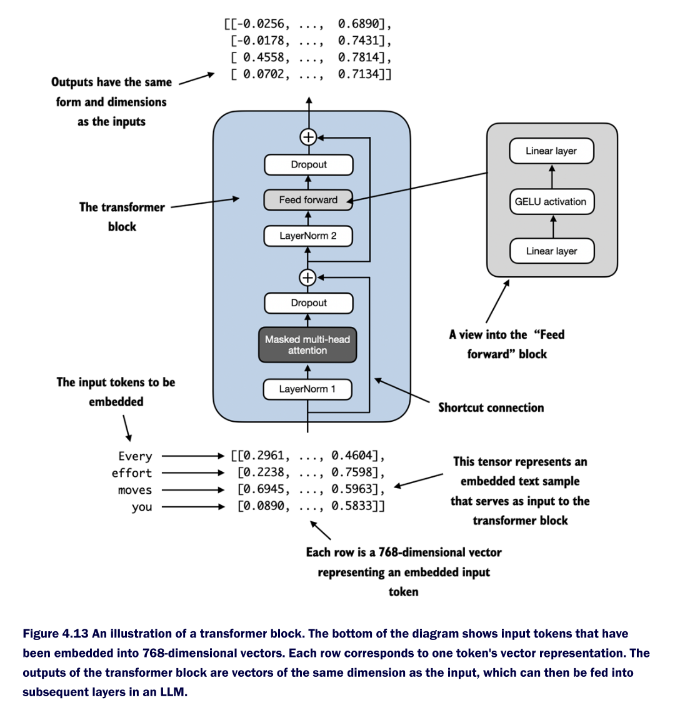

In [ ]:
# mha module
class MultiHeadAttention(nn.Module):

  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):

    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # linear layer to combine head outputs

    self.dropout = nn.Dropout(dropout) # layer di dropout

    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    # [b, num_tokens, d_out]
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # [b, num_tokens, num_heads, head_dim]
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    # [b, num_heads, num_tokens, head_dim]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2) # Q
    attn_scores = queries @ keys.transpose(2, 3) # K^T

    # causal masking
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    # normalization
    attn_weights = torch.softmax(
      attn_scores / keys.shape[-1]**0.5, dim=-1
    )

    # droput regularization
    attn_weights = self.dropout(attn_weights)
    context_vec = (attn_weights @ values).transpose(1, 2)

    # output factorization: [b, num_tokens, num_heads*head_dim]]
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # Z

    # proiezione addizionale facoltativa
    context_vec = self.out_proj(context_vec)

    return context_vec

In [ ]:
# trasformer block
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qvb_bias"]
    )

    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x

    # attention module
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    # feed-forward network
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x) # linear layer --> GELU --> linear layer
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    return x


In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) # 2 batches of 4 input tokens
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input Shape: ", x.shape)
print("Output Shape: ", output.shape)

Il fatto che le dimensioni dell'input siano uguali alle dimensioni dell'output e una scelta di design del modello fondamentale. Questo permette di applicare modelli di questi tipo ad una serie di task seq2seq: traduzione simultanea, modifica di immagini...

# 6\. The GPT model

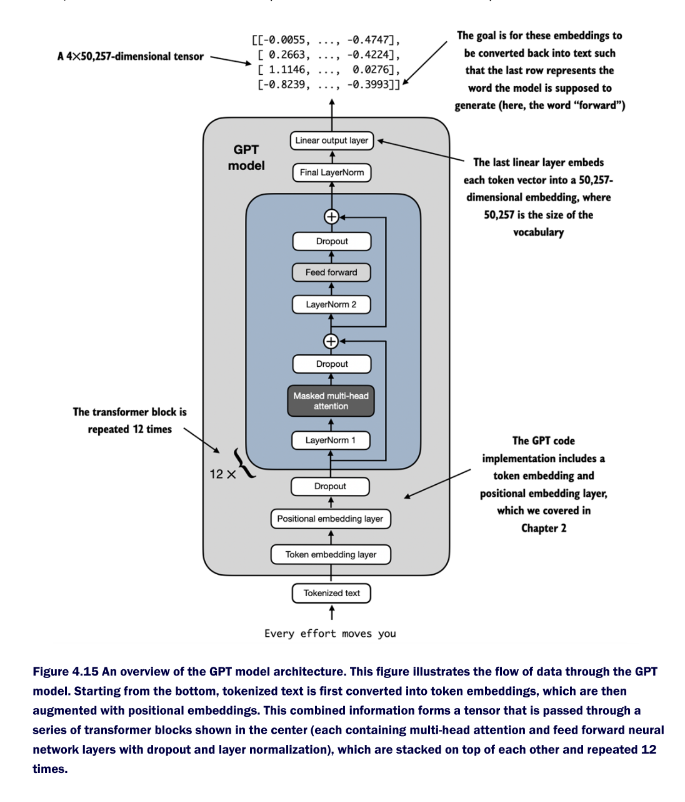

In [ ]:
class GPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
          *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(
        cfg['emb_dim'], cfg['vocab_size'], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_length = in_idx.shape

    # creazione token di input con poitional encoding
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_length, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds

    # dropout layer
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

Il modello:
1. prende in input un batch di token ID di dimensione $D$
2. ne calcola un embedding considerando encoding posizionale di dimensione d
3. regolarizza con un primo layer di dropout
4. passa la sequenza attraverso i transformer block
5. normalizza l'output dei transformer block
6. calcola i vettori logit tramite un'ultima feed-forward network ottenendo vettori di dimensione $D$


Dove $$D = \text{numero di parole presenti nel dizionario}$$

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch: \n", batch)
print("Output Shape: \n", out.shape)
print("Output: \n", out)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: \n", total_params)

In [ ]:
# weight tying
print("Token embedding layer shape: \n", model.tok_emb.weight.shape)
print("Outer layer shape: \n", model.out_head.weight.shape)

Nel modello GPT2 queste 2 matrici condividono gli stessi parametri. L'idea era quella di usare gli stessi parametri per due matrici che svolgono due lavori opposti:
- la prima: D --> d
- la seconda: d --> D

Per questo motivo il numero di parametri allenabili e minore di quello calcolato in precedenza. Questa tecnica permette di utilizzare molta meno memoria per i parametri e di diminuire drasticamente il lavoro necessario durante la fase di training. Tuttavia, utilizzare matrici allenabili diverse per i due compiti porta a performance migliori.

In [ ]:
print(f'Trainable parameters: \n {total_params - 50257*768:,}')

In [ ]:
print(f'Total size of the model: \n {total_params*4/(1024**2):.2f}')

In [ ]:
GPT_2_XLARGE = {
    "vocab_size" : 50257, # used by the BPE tokenizer
    "context_length" : 1024,
    "emb_dim" : 1600, # each input token is transformed in a 768-dimensional embedding
    "n_heads" : 25, # number of attention-heads in multi-head-attention mechanism
    "n_layers" : 48,
    "drop_rate" : 0.1, # dropout regularization
    "qvb_bias" : False # query-key-value bias
}

In [ ]:
torch.manual_seed(123)
model_XL = GPTModel(GPT_2_XLARGE)

In [ ]:
total_params_XL = sum(p.numel() for p in model_XL.parameters())
print(f'Trainable parameters: \n {total_params_XL - 50257*768:,}')
print(f'Total size of the model: \n {total_params_XL*4/(1024**2):.2f} MB')
print("\n")
print(f'Trainable parameters: \n {total_params - 50257*768:,}')
print(f'Total size of the model: \n {total_params*4/(1024**2):.2f} MB')

# 7\. Generating text

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)

In [ ]:
print(out.shape)

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):

  for _ in range(max_new_tokens): # genera un massimo di max_new_tokens parole
    idx_cond = idx[:, -context_size:] # vengono considerati gli ultimi context_size elementi della serie generata
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :] # si considera l'ultimo vettore di logit nella sequenza di output per la generazione del prossimo token
    probas = torch.softmax(logits, dim = -1)
    idx_next = torch.argmax(probas, dim = -1, keepdim = True)
    idx = torch.cat((idx, idx_next), dim = 1)

  return idx

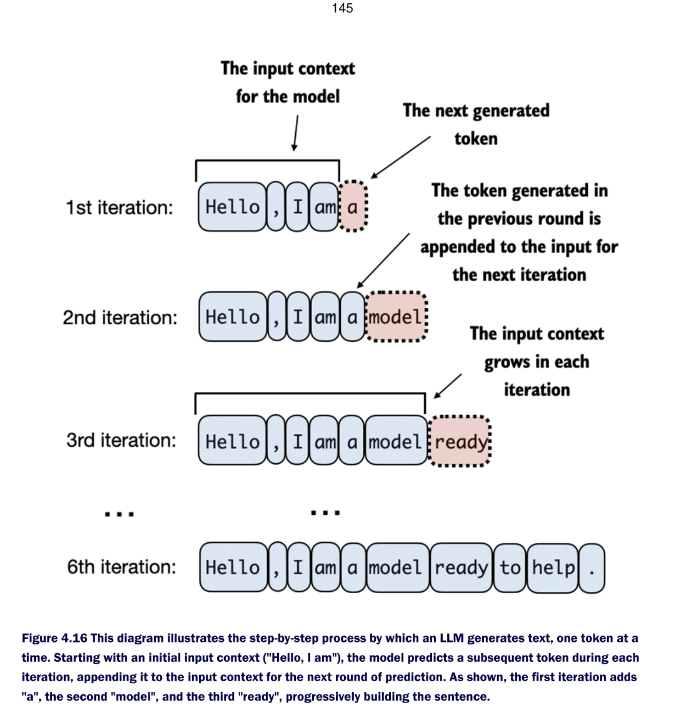

Solamente l'ultimo vettore di ogit ottenuto viene utilizzato per generare il token successivo. Quindi, guardando l'immagine qui sopra, alla prima iterazione il token `a` viene generato sulla base del vettore di logit relativo al token `am`.

Inoltre, nel momento in cui la sequenza in input diventerebbe piu lunga di quanto il modello puo gestire per costruzione, automaticamente vengono considerati gli ultimi `context_size` token. Di sopra quindi si immagini una finstra di attenzione che trasli lungo la frase generate, in manier atale da considerare solamente gli ultimi `context_size` token.

In [ ]:
start_context = 'Hello, I am'
encoded = tokenizer.encode(start_context)
print(encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(encoded_tensor.shape)

In [ ]:
model.eval() # disables dropout and gradients computing since we are not training the model
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size= GPT_CONFIG_124M['context_length']
)
print('Output: \n', out)
print("Output length: \n", out.shape)

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("\nDecoded text:")
print(decoded_text)

In [ ]:
start_context_2 = 'Neque porro quisquam est qui dolorem ipsum quia'
encoded_2 = tokenizer.encode(start_context_2)
print(encoded)
encoded_tensor_2 = torch.tensor(encoded_2).unsqueeze(0)
print(encoded_tensor_2.shape)

In [ ]:
model.eval() # disables dropout and gradients computing since we are not training the model
out_2 = generate_text_simple(
    model = model,
    idx = encoded_tensor_2,
    max_new_tokens = 6,
    context_size= GPT_CONFIG_124M['context_length']
)
print('Output: \n', out_2)
print("Output length: \n", out_2.shape)

decoded_text_2 = tokenizer.decode(out_2.squeeze(0).tolist())
print("\nDecoded text:")
print(decoded_text_2)